In [63]:
PREFIJO_SAVE = "resultados_iniciales"
def load_config():
    """
    Carga los parámetros de configuración en un diccionario para facilitar su uso.
    """
    return {
        "num_rounds": 10,
        "num_clients": 10,
        "random_seed": 42,
        "batch_size": 32,
        "num_shadow_models": 5,
        "global_model_epochs": 10,
        "shadow_train_rounds": 10,
        "shadow_data_fraction": 0.01,
        "prob_range": 0.1,
        "clients_random": False,
        "fraction": 0.1, 
        
        # RUIDO #
        "aplicar_ruido": True,
        "ruido_obj": ["gradients"],
        "ruido_per": 0.4,  # Proporción de datos afectados por ruido
        "noise_std": 0.2,   # Desviación estándar del ruido
        "epsilon": 1.0,     # Parámetro de privacidad diferencial
        "delta": 1e-5,      # Delta para ruido gaussiano
        "sensitivity": 1.0, # Sensibilidad del mecanismo de ruido
        "privacy_type": "gaussian",  # Tipo de ruido a aplicar
        "selected_layers": "all", # [0, -1]  # Aplica ruido a todas las capas

        # LABEL FLIPPING #
        "label_flipping": False,
        "flipping_antes": False,
        "prob_flip_0": 0.2,
        "prob_flip_1": 0.2,
        "flip_target": "Slice",
        
        # RESULTADOS #
        "property_threshold": 0.5,
        "learning_rate": 0.1,
        "data_file_path": 'label_bi_10.csv',
        "prefijo_save": "resultados_iniciales",
    }

config = load_config()

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, confusion_matrix
import csv
import os
import random
import logging
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor
import tqdm
from numpy.random import laplace, normal
from scipy.stats import bootstrap


SEED = 42

def set_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)  

set_seed()



In [65]:
#### LOG ####
LOG_DIR = 'logs'
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

if not os.path.exists(config["prefijo_save"]):
    os.makedirs(config["prefijo_save"])
    
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(os.path.join(LOG_DIR, 'execution.log')),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(__name__)

In [66]:
def validate_configuration():
    """
    Valida las configuraciones de parámetros y asegura que las combinaciones sean coherentes.
    """
    logger.info("Validating configuration...")

    # Informar configuraciones redundantes
    if not config["label_flipping"] and config["flipping_antes"]:
        raise ValueError("FLIPPING_ANTES=True no tiene sentido cuando LABEL_FLIPPING=False.")

    if not config["aplicar_ruido"] and not config["label_flipping"]:
        logger.info("Ni ruido ni label flipping están activados. El experimento no incluye perturbaciones en los datos.")

    # Validar parámetros relacionados con ruido
    if config["aplicar_ruido"]:
        if config["epsilon"] <= 0:
            raise ValueError("EPSILON debe ser mayor que 0.")
        if config["delta"] is not None and not (0 < config["delta"] < 1):
            raise ValueError("DELTA debe estar entre 0 y 1 si se usa ruido gaussiano.")
        if config["sensitivity"] <= 0:
            raise ValueError("SENSITIVITY debe ser mayor que 0.")
        if not all(obj in ["gradients", "data"] for obj in config["ruido_obj"]):
            raise ValueError("RUÍDO_OBJ solo puede contener 'gradients' o 'data'.")

    # Validar parámetros relacionados con flipping
    if config["label_flipping"]:
        if not (0 <= config["prob_flip_0"] <= 1):
            raise ValueError("PROB_FLIP_0 debe estar entre 0 y 1.")
        if not (0 <= config["prob_flip_1"] <= 1):
            raise ValueError("PROB_FLIP_1 debe estar entre 0 y 1.")

    logger.info("Configuration validation completed successfully.")


In [67]:
#### DATA ####
def load_data(file_path):
    """
    Carga un archivo CSV y devuelve un DataFrame.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"El archivo {file_path} no se encontró.")
    
    df = pd.read_csv(file_path)
    return df

def preprocess_data(df, fraction=config["fraction"]):
    """
    Preprocesa los datos, filtra columnas necesarias y aplica muestreo.
    """
    necessary_columns = [
        'Src IP', 'Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
        'Fwd Packet Length Std', 'ACK Flag Count', 'Fwd Seg Size Min', 'label', 'Slice'
    ]
    
    df = df[necessary_columns].dropna()
    df = df.sample(frac=fraction, random_state = SEED).reset_index(drop=True)

    X = df.drop(['label', 'Slice'], axis=1)
    y_label = df['label']
    y_slice = df['Slice']

    return X, y_label, y_slice

def create_client_data(X, y_label, y_slice, config):
    """
    Divide los datos para los clientes y aplica ruido o flipping si está configurado.

    Parameters:
        X (DataFrame): Características de los datos.
        y_label (Series): Etiquetas de clasificación.
        y_slice (Series): Propiedad objetivo.
        config (dict): Configuración del experimento.

    Returns:
        list: Lista de datos de clientes con propiedades ajustadas.
    """
    num_clients = config["num_clients"]  # Extraer el número de clientes correctamente
    
    logger.info(f"Creating data for {num_clients} clients with security configurations")
    logger.info(f"Shape de X antes de dividir clientes: {X.shape}")
    
    logger.info(f"Creating data for {num_clients} clients with security configurations")

    # Separar datos con y sin propiedad
    X_with_property = X[y_slice == 1]
    y_label_with_property = y_label[y_slice == 1]
    X_without_property = X[y_slice == 0]
    y_label_without_property = y_label[y_slice == 0]

    if num_clients % 2 != 0:
        raise ValueError("El número de clientes debe ser par para balancear propiedades.")
    
    logger.info(f"Shape de X con propiedad: {X_with_property.shape}, sin propiedad: {X_without_property.shape}")

    min_data_size = min(
        len(X_with_property) // (num_clients // 2), 
        len(X_without_property) // (num_clients // 2)
    )

    client_data = []

    for i in range(num_clients // 2):
        client_data.append({
            'X': X_with_property.iloc[i * min_data_size:(i + 1) * min_data_size],
            'y_label': y_label_with_property.iloc[i * min_data_size:(i + 1) * min_data_size].copy(),
            'y_slice': 1,
            'has_property': True
        })

        client_data.append({
            'X': X_without_property.iloc[i * min_data_size:(i + 1) * min_data_size],
            'y_label': y_label_without_property.iloc[i * min_data_size:(i + 1) * min_data_size].copy(),
            'y_slice': 0,
            'has_property': False
        })
    logger.info(f"Shape of client data input: {client_data[0]['X'].shape}")

    return client_data



In [68]:
#### MODELS ####
def split_data_for_models(X, y_label, y_slice, config):
    """
    Divide los datos en conjuntos para el modelo global y los modelos sombra.

    Parameters:
        X (DataFrame): Características de los datos.
        y_label (Series): Etiquetas de clasificación.
        y_slice (Series): Propiedad objetivo.
        config (dict): Configuración de parámetros.

    Returns:
        Tuple: (Conjunto global, Conjunto shadow, Número de muestras shadow).
    """
    logger.info("Dividiendo datos para el modelo global y los modelos sombra.")

    num_shadow_samples = int(len(X) * config['shadow_data_fraction'])
    indices = np.arange(len(X))
    #np.random.shuffle(indices)
    indices = np.argsort(X.index)  # Ordena de manera fija los datos

    shadow_indices = indices[:num_shadow_samples]
    global_indices = indices[num_shadow_samples:]

    X_shadow, y_label_shadow, y_slice_shadow = X.iloc[shadow_indices], y_label.iloc[shadow_indices], y_slice.iloc[shadow_indices]
    X_global, y_label_global, y_slice_global = X.iloc[global_indices], y_label.iloc[global_indices], y_slice.iloc[global_indices]

    logger.info(f"Datos divididos: {len(X_global)} para el modelo global, {len(X_shadow)} para los modelos sombra.")
    
    return (X_global, y_label_global, y_slice_global), (X_shadow, y_label_shadow, y_slice_shadow), len(X_shadow)

def create_global_model(input_shape, config):
    """
    Crea un modelo de red neuronal para aprendizaje federado.

    Parameters:
        input_shape (int): Número de características de entrada.
        config (dict): Configuración de entrenamiento.

    Returns:
        tf.keras.Model: Modelo compilado.
    """
    logger.info(f"Creando modelo global con input shape {input_shape}")

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_shadow_model(input_shape, config):
    """
    Crea un modelo sombra más simple para inferencia de propiedades.

    Parameters:
        input_shape (int): Dimensión de entrada.
        config (dict): Configuración del modelo.

    Returns:
        tf.keras.Model: Modelo de shadow compilado.
    """
    logger.info(f"Creando modelo sombra con input shape {input_shape}")

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def select_clients(round_num, clients_with_property, clients_without_property):
    """
    Selecciona los clientes de forma determinista:
    - En rondas pares: Se eligen clientes con la propiedad.
    - En rondas impares: Se eligen clientes sin la propiedad.
    """
    return clients_with_property if round_num % 2 == 0 else clients_without_property

def initialize_clients(client_data, global_model, global_model_epochs, batch_size):

    def init_client(client_id, data):
        # Pasar el modelo global completo
        return SimulatedFlowerClient(client_id, data, global_model, global_model_epochs, batch_size)

    # Paralelizar la inicialización de los clientes
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = [executor.submit(init_client, i, data) for i, data in enumerate(client_data)]
        clients = [f.result() for f in futures]

    return clients

class SimulatedFlowerClient:
    def __init__(self, client_id, data, global_model, config, batch_size):
        """
        Inicializa un cliente simulado con sus datos y modelo en Federated Learning.

        Parameters:
            client_id (int): Identificador único del cliente.
            data (dict): Diccionario con 'X' (features) y 'y_label' (etiquetas).
            global_model (tf.keras.Model): Modelo central para copiar pesos.
            config (dict): Configuración del experimento.
        """
        self.data = data
        self.client_id = client_id
        self.X = data["X"]
        self.y_label = data["y_label"]
        self.config = config

        # Inicializar el modelo copiando el global
        self.model = tf.keras.models.clone_model(global_model)
        self.model.set_weights(global_model.get_weights())
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            
    def get_parameters(self):
        """Devuelve los parámetros actuales del modelo del cliente."""
        return self.model.get_weights()

    def fit(self, global_weights):
        """
        Entrena el modelo localmente y aplica transformaciones si es necesario.
        """
        self.model.set_weights(global_weights)
        self.model.fit(self.X, self.y_label, epochs=self.config["global_model_epochs"],
                       batch_size=self.config["batch_size"], verbose=0)

        updates = [new_w - old_w for new_w, old_w in zip(self.model.get_weights(), global_weights)]

        # Aplicar ruido si está configurado
        if self.config["aplicar_ruido"]:
            if "gradients" in self.config["ruido_obj"]:
                updates = [apply_noise_to_gradients(layer, self.config) for layer in updates]
            if "data" in self.config["ruido_obj"]:
                self.X = add_noise(self.X.to_numpy(), self.config)  # Se aplica ruido a los datos

        return self.model.get_weights(), len(self.X), {"updates": updates}

    def evaluate(self, global_weights):
        """
        Evalúa el modelo global en los datos locales del cliente.

        Parameters:
            global_weights (list): Pesos del modelo global.

        Returns:
            tuple: (Loss, número de muestras, metadatos de precisión).
        """
        self.model.set_weights(global_weights)
        loss, accuracy = self.model.evaluate(self.X, self.y_label, verbose=0)
        return loss, len(self.X), {"accuracy": accuracy}

def train_shadow_models(X_shadow, y_label_shadow, y_slice_shadow, num_shadow_models, global_model, config):
    """
    Entrena los modelos sombra usando las actualizaciones de los pesos.

    Parameters:
        X_shadow (DataFrame): Conjunto de datos para los shadow models.
        y_label_shadow (Series): Etiquetas asociadas a X_shadow.
        y_slice_shadow (Series): Información de propiedad para inferencia.
        global_model (tf.keras.Model): Modelo base del entrenamiento.
        config (dict): Configuración del experimento.

    Returns:
        list: Lista de modelos sombra entrenados.
    """

    
    logger.info(f"Training {config['num_shadow_models']} shadow models prior to federated learning.")

    # Resetear índices para evitar errores de acceso
    y_slice_shadow = y_slice_shadow.reset_index(drop=True)

    # Crear modelos sombra con la misma estructura del modelo global
    shadow_models = []
    for i in range(config['num_shadow_models']):
        logger.info(f"Training shadow model {i + 1}/{config['num_shadow_models']}")

        shadow_model = tf.keras.models.clone_model(global_model)
        shadow_model.set_weights(global_model.get_weights())
        shadow_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Entrenar el modelo con todos los datos shadow
        shadow_model.fit(X_shadow, y_label_shadow, epochs=config['global_model_epochs'], 
                         batch_size=config['batch_size'], verbose=0)
        shadow_models.append(shadow_model)

    logger.info("All shadow models trained successfully.")
    return shadow_models

def infer_with_shadow_models(shadow_models, updates, config):
    """
    Realiza inferencia usando los modelos sombra.
    """
    if len(updates) == 0:
        logger.error("Lista de updates está vacía. No hay actualizaciones para inferencia.")
        raise ValueError("Lista de updates está vacía. No hay actualizaciones para inferencia.")

    # Normalizar el tamaño de los updates
    uniform_size = max([u.size for u in updates])
    normalized_updates = [np.pad(u.flatten(), (0, uniform_size - u.size), 'constant') for u in updates]

    # Tomar solo los primeros 9 valores para cada update
    truncated_updates = np.array([u[:9] for u in normalized_updates])

    # Asegurar que cada fila es una muestra de entrada con 9 características
    flattened_updates = truncated_updates.reshape(-1, 9)

    logger.debug(f"Shape de updates normalizados: {truncated_updates.shape}")
    logger.debug(f"Shape de flattened_updates: {flattened_updates.shape}")

    # Aplicar predicción a cada modelo sombra
    probabilities = [model.predict(flattened_updates, verbose=0).flatten() for model in shadow_models]
    
    return np.mean(probabilities)
def normalize_updates(client_updates):
    """
    Normaliza los updates de los clientes asegurando que todos tengan la misma longitud.
    """
    # Obtener el número de capas en las actualizaciones
    num_layers = len(client_updates[0])
    
    # Para cada capa, encontrar el tamaño máximo de los arrays
    max_sizes = [max([update[layer_idx].size for update in client_updates]) for layer_idx in range(num_layers)]
    
    # Normalizar cada capa por separado
    normalized_updates = []
    for update in client_updates:
        normalized_update = []
        for layer_idx in range(num_layers):
            layer_update = update[layer_idx]
            # Rellenar con ceros si es necesario
            normalized_layer = np.pad(layer_update.flatten(), (0, max_sizes[layer_idx] - layer_update.size), 'constant')
            normalized_update.append(normalized_layer)
        normalized_updates.append(normalized_update)
    
    return normalized_updates


def average_client_updates(client_updates):
    """
    Promedia las actualizaciones de los clientes asegurándose de que todas tengan la misma longitud.
    """
    if len(client_updates) == 0:
        raise ValueError("La lista de client_updates está vacía. No se puede calcular el promedio.")

    # Normalizar las actualizaciones
    normalized_updates = normalize_updates(client_updates)
    
    # Obtener el número de capas
    num_layers = len(client_updates[0])
    
    # Promediar las actualizaciones por capa
    averaged_updates = []
    for layer_idx in range(num_layers):
        # Obtener todas las actualizaciones para esta capa
        layer_updates = [update[layer_idx] for update in normalized_updates]
        # Promediar las actualizaciones de esta capa
        averaged_layer = np.mean(layer_updates, axis=0)
        averaged_updates.append(averaged_layer)
    
    return averaged_updates


def custom_model(input_shape, config=None):
    """
    Crea un modelo de inferencia personalizado para shadow models.

    Parameters:
        input_shape (int): Dimensión de entrada del modelo.
        config (dict, opcional): Configuración para ajustar la arquitectura.

    Returns:
        tf.keras.Model: Modelo compilado.
    """
    logger.info(f"Creating custom shadow model with input shape {input_shape}")

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate'] if config else 0.001),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [69]:
#### SEGURIDAD ####

def apply_label_flipping(y_data, flip_target, prob_flip_0, prob_flip_1):
    """
    Aplica flipping de etiquetas o propiedades basado en el parámetro flip_target.
    """
    if flip_target not in ["label", "Slice"]:
        raise ValueError(f"Invalid flip_target: {flip_target}. Must be 'label' or 'Slice'.")

    if isinstance(y_data, pd.Series):
        # Caso Series: se asume que el target es directamente la serie
        target_data = y_data

    elif isinstance(y_data, pd.DataFrame):
        # Caso DataFrame: se accede a la columna específica indicada por flip_target
        if flip_target in y_data.columns:
            target_data = y_data[flip_target]
        else:
            raise KeyError(f"Column '{flip_target}' is not found in DataFrame data.")

    else:
        raise TypeError(f"Unsupported data type: {type(y_data)}. Must be pandas DataFrame or Series.")

    # Flipping 0 -> 1
    flip_0_indices = target_data[target_data == 0].index
    num_flips_0_to_1 = int(len(flip_0_indices) * prob_flip_0)
    flipped_0_indices = np.random.choice(flip_0_indices, num_flips_0_to_1, replace=False)
    target_data.loc[flipped_0_indices] = 1

    # Flipping 1 -> 0
    flip_1_indices = target_data[target_data == 1].index
    num_flips_1_to_0 = int(len(flip_1_indices) * prob_flip_1)
    flipped_1_indices = np.random.choice(flip_1_indices, num_flips_1_to_0, replace=False)
    target_data.loc[flipped_1_indices] = 0

    logger.info(f"Flipped {num_flips_0_to_1} entries from 0 -> 1 and {num_flips_1_to_0} from 1 -> 0.")

    return target_data


def add_noise(data, config):
    """
    Aplica ruido diferencialmente privado a los datos o actualizaciones según el tipo seleccionado.
    """
    ruido_per = config["ruido_per"]
    ruido_std = config["noise_std"]
    epsilon = config["epsilon"]
    delta = config.get("delta", None)
    sensitivity = config["sensitivity"]
    privacy_type = config["privacy_type"]

    if not (0 <= ruido_per <= 1):
        raise ValueError("ruido_per debe estar entre 0 y 1.")
    if epsilon <= 0:
        raise ValueError("epsilon debe ser mayor que 0.")
    if privacy_type not in ["gaussian", "laplacian"]:
        raise ValueError("privacy_type debe ser 'gaussian' o 'laplacian'.")

    num_samples = int(len(data) * ruido_per)
    noisy_indices = np.random.choice(len(data), size=num_samples, replace=False)

    if privacy_type == "gaussian":
        noise_scale = sensitivity * np.sqrt(2 * np.log(1.25 / delta)) / epsilon if delta else ruido_std
        noise = np.random.normal(0, noise_scale, size=(num_samples, data.shape[1]))
    else:  # Laplaciano
        noise_scale = sensitivity / epsilon
        noise = np.random.laplace(0, noise_scale, size=(num_samples, data.shape[1]))

    data_noisy = data.copy()
    data_noisy[noisy_indices, :] += noise
    return data_noisy

def apply_noise(data, ruido_per, ruido_std, epsilon, delta, sensitivity, ruido_antes, privacy_type="gaussian"):
    """
    Aplica ruido con privacidad diferencial a los datos o actualizaciones.
    """
    if privacy_type not in ["gaussian", "laplacian"]:
        raise ValueError("privacy_type debe ser 'gaussian' o 'laplacian'.")

    return add_noise(data, ruido_per)


def apply_noise_to_gradients(gradients, config):
    """
    Aplica ruido diferencialmente privado a los gradientes antes de enviarlos al servidor en FL.
    
    Parameters:
        gradients (list): Lista de arrays de gradientes por capa.
        config (dict): Configuración con los parámetros de ruido.

    Returns:
        list: Lista de gradientes con ruido aplicado en las capas seleccionadas.
    """
    epsilon = config["epsilon"]
    delta = config.get("delta", None)
    sensitivity = config["sensitivity"]
    privacy_type = config["privacy_type"]
    selected_layers = config.get("selected_layers", "all")  # Puede ser una lista de índices o "all"

    if epsilon <= 0:
        raise ValueError("epsilon debe ser mayor que 0.")

    # Calcular la escala del ruido
    if privacy_type == "gaussian":
        noise_scale = sensitivity * np.sqrt(2 * np.log(1.25 / delta)) / epsilon
    else:  # Laplaciano
        noise_scale = sensitivity / epsilon

    # Si "all", aplicar ruido a todas las capas, si no, solo a las seleccionadas
    for i in range(len(gradients)):
        if selected_layers == "all" or i in selected_layers:
            if privacy_type == "gaussian":
                noise = np.random.normal(0, noise_scale, size=gradients[i].shape)
            else:
                noise = np.random.laplace(0, noise_scale, size=gradients[i].shape)
            
            gradients[i] += noise  # Aplicar ruido

    return gradients




def apply_flipping(data, flip_target, prob_flip_0, prob_flip_1):
    """
    Aplica flipping de etiquetas o propiedades basado en configuraciones.
    """
    return apply_label_flipping(data, flip_target, prob_flip_0, prob_flip_1)


In [70]:
#### OUTPUTS ####
def calculate_correct_predictions(results, config):
    """
    Calcula la cantidad de predicciones correctas e incorrectas basadas en la propiedad detectada.
    
    Parameters:
        results (list): Lista de resultados de la simulación.
        config (dict): Configuración del experimento.

    Returns:
        tuple: (Correctos, Incorrectos, Threshold Dinámico).
    """
    correct_predictions = 0
    incorrect_predictions = 0
    dynamic_thresholds = calculate_dynamic_threshold(results, config)

    # Ignorar las primeras tres rondas
    for i in range(3, len(results)):
        current_prob = results[i]['property_probability']
        previous_prob = results[i - 1]['property_probability']
        previous_property = results[i - 1]['has_property']
        current_property = results[i]['has_property']
        threshold = dynamic_thresholds[i]

        # Clasificación basada en transiciones de propiedad
        if not previous_property and not current_property:
            is_correct = abs(current_prob - previous_prob) < threshold * 0.1
        elif previous_property and not current_property:
            is_correct = current_prob < previous_prob
        elif not previous_property and current_property:
            is_correct = current_prob > previous_prob
        elif previous_property and current_property:
            is_correct = abs(current_prob - previous_prob) < threshold * 0.1
        else:
            is_correct = False

        if is_correct:
            correct_predictions += 1
        else:
            incorrect_predictions += 1

    total_predictions = correct_predictions + incorrect_predictions
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

    logger.info(f"Correct predictions: {correct_predictions}, Incorrect predictions: {incorrect_predictions}, Accuracy: {accuracy:.4f}")
    return correct_predictions, incorrect_predictions, dynamic_thresholds

def plot_results(results, output_path):
    """
    Genera gráficos de la evolución de la probabilidad detectada, pérdida y precisión.

    Parameters:
        results (list): Resultados de la simulación.
        output_path (str): Directorio para guardar las imágenes.
    """
    # Ignorar las primeras tres rondas para evitar ruido inicial
    round_nums = [r['round'] for r in results][3:]
    probabilities = [r['property_probability'] for r in results][3:]
    thresholds = [r['threshold_used'] for r in results][3:]
    losses = [r['loss'] for r in results][3:]
    accuracies = [r['accuracy'] for r in results][3:]
    property_present = [r['has_property'] for r in results][3:]

    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    # Gráfico 1: Evolución de la probabilidad detectada vs Threshold dinámico
    round_nums = [r['round'] for r in results][3:]
    probabilities = [r['property_probability'] for r in results][3:]
    losses = [r['loss'] for r in results][3:]
    accuracies = [r['accuracy'] for r in results][3:]
    property_present = [r['has_property'] for r in results][3:]

    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    # Gráfico 1: Probabilidad por ronda
    axs[0].plot(round_nums, probabilities, marker='o', color='blue', label='Property Probability')
    for round_, prob, present in zip(round_nums, probabilities, property_present):
        if present:
            axs[0].scatter(round_, prob, color='red', zorder=5, label='Rounds with Property' if round_nums.index(round_) == 0 else "")
    axs[0].set_xlabel('Round')
    axs[0].set_ylabel('Property Probability')
    axs[0].set_title('Property Probability by Round (ignoring first 3 rounds)')
    axs[0].grid(True)
    axs[0].legend()

    # Gráfico 2: Pérdida y Precisión del modelo global
    ax1 = axs[1]
    ax1.plot(round_nums, losses, label='Loss', color='red', marker='x')
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Loss', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(round_nums, accuracies, label='Accuracy', color='blue', marker='o')
    ax2.set_ylabel('Accuracy', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    fig.tight_layout()
    plt.savefig(f"{output_path}/probability_loss_accuracy.png")
    plt.close()

def plot_combined_roc_threshold(fpr, tpr, thresholds, auc_roc, optimal_threshold, output_path):
    """
    Genera una imagen con dos gráficos:
    - Izquierda: Curva ROC.
    - Derecha: TPR/FPR vs Threshold con umbral óptimo.
    """
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfico 1: Curva ROC
    axs[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_roc:.2f})')
    axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('ROC Curve')
    axs[0].legend(loc="lower right")
    axs[0].grid(True)

    # Gráfico 2: TPR/FPR vs Threshold
    axs[1].plot(thresholds, tpr, label='True Positive Rate (TPR)', color='green', lw=2)
    axs[1].plot(thresholds, fpr, label='False Positive Rate (FPR)', color='red', lw=2)
    axs[1].axvline(optimal_threshold, color='blue', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
    axs[1].set_xlabel('Threshold')
    axs[1].set_ylabel('Rate')
    axs[1].set_title('TPR and FPR vs. Threshold')
    axs[1].legend(loc="best")
    axs[1].grid(True)

    fig.tight_layout()
    plt.savefig(f"{output_path}/roc_threshold.png")
    plt.close()
    
def calculate_and_log_metrics(results, config):
    """
    Calcula las métricas principales y devuelve un diccionario con los resultados.

    Parameters:
        results (list): Lista de resultados de la simulación.
        config (dict): Configuración del experimento.

    Returns:
        tuple: (Diccionario de métricas, fpr, tpr, thresholds, custom_precision).
    """
    y_true = [r['has_property'] for r in results][3:]  # Ignorar las 3 primeras rondas
    y_prob = [r['property_probability'] for r in results][3:]
    dynamic_thresholds = [r.get('threshold_used', config["property_threshold"]) for r in results][3:]  # Evitar errores de key

    # Clasificar usando el threshold dinámico
    y_pred_dynamic = [1 if prob > thresh else 0 for prob, thresh in zip(y_prob, dynamic_thresholds)]

    # Calcular curva ROC y encontrar el threshold óptimo
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc_roc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx] if len(thresholds) > 0 else config["property_threshold"]

    # Clasificar usando el threshold óptimo de ROC
    y_pred_optimal = [1 if prob > optimal_threshold else 0 for prob in y_prob]

    # Calcular métricas para el threshold dinámico
    cm_dynamic = confusion_matrix(y_true, y_pred_dynamic)
    tn_dyn, fp_dyn, fn_dyn, tp_dyn = cm_dynamic.ravel() if cm_dynamic.shape == (2,2) else (0, 0, 0, 0)
    precision_dyn = tp_dyn / (tp_dyn + fp_dyn) if (tp_dyn + fp_dyn) > 0 else 0
    recall_dyn = tp_dyn / (tp_dyn + fn_dyn) if (tp_dyn + fn_dyn) > 0 else 0
    f1_dyn = 2 * (precision_dyn * recall_dyn) / (precision_dyn + recall_dyn) if (precision_dyn + recall_dyn) > 0 else 0

    # Calcular métricas para el threshold óptimo
    cm_optimal = confusion_matrix(y_true, y_pred_optimal)
    tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel() if cm_optimal.shape == (2,2) else (0, 0, 0, 0)
    precision_opt = tp_opt / (tp_opt + fp_opt) if (tp_opt + fp_opt) > 0 else 0
    recall_opt = tp_opt / (tp_opt + fn_opt) if (tp_opt + fn_opt) > 0 else 0
    f1_opt = 2 * (precision_opt * recall_opt) / (precision_opt + recall_opt) if (precision_opt + recall_opt) > 0 else 0

    # Precisión basada en transiciones de probabilidad
    correct_transitions, incorrect_transitions, _ = calculate_correct_predictions(results, config)
    total_transitions = correct_transitions + incorrect_transitions
    custom_precision = (correct_transitions / total_transitions) * 100 if total_transitions > 0 else 0

    # Calcular intervalos de confianza
    precision_ci_dyn = intervalo_confianza(y_pred_dynamic)
    recall_ci_dyn = intervalo_confianza(y_true)
    auc_ci = intervalo_confianza(y_prob)
    f1_ci_dyn = intervalo_confianza([f1_dyn] * len(y_true))

    metrics = {
        'ROC AUC': auc_roc,
        'Optimal Threshold': optimal_threshold,
        'Precision (Dynamic)': precision_dyn,
        'Recall (Dynamic)': recall_dyn,
        'F1-Score (Dynamic)': f1_dyn,
        'True Positive (Dynamic)': tp_dyn,
        'False Positive (Dynamic)': fp_dyn,
        'True Negative (Dynamic)': tn_dyn,
        'False Negative (Dynamic)': fn_dyn,
        'Precision (Optimal)': precision_opt,
        'Recall (Optimal)': recall_opt,
        'F1-Score (Optimal)': f1_opt,
        'True Positive (Optimal)': tp_opt,
        'False Positive (Optimal)': fp_opt,
        'True Negative (Optimal)': tn_opt,
        'False Negative (Optimal)': fn_opt,
        'Custom Precision': custom_precision
    }
    
    # Agregar intervalos de confianza
    metrics.update({
        'Precision CI (Dynamic)': f"{precision_ci_dyn[0]:.4f} - {precision_ci_dyn[1]:.4f}",
        'Recall CI (Dynamic)': f"{recall_ci_dyn[0]:.4f} - {recall_ci_dyn[1]:.4f}",
        'ROC AUC CI': f"{auc_ci[0]:.4f} - {auc_ci[1]:.4f}",
        'F1-Score CI (Dynamic)': f"{f1_ci_dyn[0]:.4f} - {f1_ci_dyn[1]:.4f}"
    })
    
    return metrics, fpr, tpr, thresholds, custom_precision

def save_results_to_csv(results, transitions, metrics):
    """
    Guarda los resultados en tres CSV:
    - Resultados detallados por ronda.
    - Transiciones entre rondas.
    - Resultados finales (métricas globales).
    """
    if results:
        fieldnames = list(results[0].keys())  # Asegurar que las claves coincidan
    else:
        fieldnames = ['Round', 'Prediction', 'Probability', 'Clients with Property', 
                      'Clients without Property', 'Has Property', 'Loss', 'Accuracy']

    # Resultados por Ronda
    with open(f"{PREFIJO_SAVE}/round_results.csv", 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for r in results:
            writer.writerow(r)

    # Transiciones
    if transitions:
        fieldnames_transitions = list(transitions[0].keys())
        with open(f"{PREFIJO_SAVE}/transitions.csv", 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames_transitions)
            writer.writeheader()
            for t in transitions:
                writer.writerow(t)
    
    # Resultados Finales
    with open(f"{PREFIJO_SAVE}/final_metrics.csv", 'w', newline='') as csvfile:
        fieldnames_metrics = list(metrics.keys())
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames_metrics)
        writer.writeheader()
        writer.writerow(metrics)

def calculate_dynamic_threshold(results, config, min_adjustment=config["prob_range"]):
    """
    Calcula un threshold dinámico basado en la evolución de la probabilidad detectada.

    - Si la predicción es incorrecta, ajusta el threshold para mejorar la precisión.
    - Usa un ajuste mínimo `min_adjustment` para evitar cambios bruscos.

    Parameters:
        results (list): Resultados de la simulación.
        config (dict): Configuración del experimento.
        min_adjustment (float): Valor mínimo de ajuste del threshold.

    Returns:
        list: Lista de thresholds dinámicos por ronda.
    """
    thresholds = [config["property_threshold"]]

    for i in range(1, len(results)):
        prev_prob = results[i - 1]['property_probability']
        curr_prob = results[i]['property_probability']
        actual_property = results[i]['has_property']
        pred_property = results[i]['prediction']

        # Ajuste basado en errores
        if pred_property != actual_property:
            if pred_property:  # Falso positivo, threshold debe subir
                new_threshold = min(thresholds[-1] + min_adjustment, 1.0)
            else:  # Falso negativo, threshold debe bajar
                new_threshold = max(thresholds[-1] - min_adjustment, 0.0)
        else:
            # Ajustar suavemente basado en la evolución de la probabilidad
            if abs(curr_prob - prev_prob) > min_adjustment:
                new_threshold = (curr_prob + prev_prob) / 2
            else:
                new_threshold = thresholds[-1]

        thresholds.append(new_threshold)

    return thresholds

def plot_noisy_vs_clean_accuracy(noisy_results, clean_results, output_path):
    """
    Compara la precisión de FL con y sin ruido en un solo gráfico.
    """
    rounds = range(len(noisy_results))
    noisy_acc = [r['accuracy'] for r in noisy_results]
    clean_acc = [r['accuracy'] for r in clean_results]

    plt.figure(figsize=(10, 5))
    plt.plot(rounds, noisy_acc, label='Con Ruido', color='red')
    plt.plot(rounds, clean_acc, label='Sin Ruido', color='blue')
    plt.xlabel("Rondas")
    plt.ylabel("Precisión")
    plt.title("Impacto del Ruido en la Precisión de FL")
    plt.legend()
    plt.grid()
    plt.savefig(f"{output_path}/noisy_vs_clean_accuracy.png")
    plt.close()


def analyze_probability_transitions(results, config):
    """
    Analiza las transiciones de probabilidad entre rondas usando filtrado dinámico.

    Parameters:
        results (list): Resultados de la simulación.
        config (dict): Configuración del experimento.

    Returns:
        list: Lista de transiciones clasificadas.
    """
    transitions = []
    probabilities = [r['property_probability'] for r in results][3:]
    rounds = [r['round'] for r in results][3:]

    # Filtrar valores extremos
    prob_mean = np.mean(probabilities)
    prob_std = np.std(probabilities)
    lower_bound = prob_mean - 2 * prob_std
    upper_bound = prob_mean + 2 * prob_std
    filtered_probs = [p if lower_bound <= p <= upper_bound else prob_mean for p in probabilities]

    min_prob, max_prob = min(filtered_probs), max(filtered_probs)
    range_value = max_prob - min_prob if max_prob > min_prob else 1
    significant_move = range_value * config["prob_range"]

    for i in range(1, len(filtered_probs)):
        prev_prob = filtered_probs[i - 1]
        curr_prob = filtered_probs[i]
        diff = curr_prob - prev_prob
        transition = "stable"

        if abs(diff) > significant_move:
            transition = "increase" if diff > 0 else "decrease"

        transitions.append({
            'round': rounds[i],
            'prev_probability': prev_prob,
            'current_probability': curr_prob,
            'transition': transition
        })

    logger.info(f"Transitions analyzed: {len(transitions)} processed.")
    return transitions

def intervalo_confianza(data, confidence_level=0.95, n_resamples=1000):
    """
    Calcula el intervalo de confianza usando bootstrap.
    """
    data = np.array(data)

    # Verificar si los datos son válidos
    if np.all(data == data[0]):  # Si todos los valores son iguales
        logger.warning("Los datos son degenerados (todos los valores son iguales).")

        return (data[0], data[0])  # Retorna el mismo valor como intervalo
    
    if np.isnan(data).any() or np.isinf(data).any():  # Si hay valores inválidos
        raise ValueError("Los datos contienen valores NaN o infinitos.")
    
    # Calcular el intervalo de confianza
    res = bootstrap((data,), np.mean, confidence_level=confidence_level, n_resamples=n_resamples)
    return res.confidence_interval.low, res.confidence_interval.high


In [71]:
#### EXPERIMENT ####
def simulated_federated_learning(clients, shadow_models, global_model, config):
    """
    Simula el aprendizaje federado con clientes seleccionados y shadow models.

    Parameters:
        clients (list): Lista de clientes en FL.
        shadow_models (list): Modelos sombra entrenados.
        global_model (tf.keras.Model): Modelo central.
        config (dict): Configuración del experimento.

    Returns:
        list: Resultados de cada ronda de entrenamiento.
    """
    logger.info(f"Starting simulated federated learning with {config['num_rounds']} rounds")
    results = []

    clients_with_property = [client for client in clients if client.data['has_property']]
    clients_without_property = [client for client in clients if not client.data['has_property']]

    logger.info(f"{len(clients_with_property)} clients have the property.")
    logger.info(f"{len(clients_without_property)} clients do not have the property.")

    for round_num in tqdm.tqdm(range(1, config['num_rounds'] + 1), desc="Federated Learning Progress"):
        logger.info(f"Starting round {round_num}")
        
        # Selección de clientes
        use_property_clients = random.choice([True, False]) if config['clients_random'] else (round_num % 2 == 0)
        selected_clients = clients_with_property if use_property_clients else clients_without_property

        logger.info(f"Training {len(selected_clients)} selected clients...")

        # Obtener pesos actuales del modelo global
        global_weights = global_model.get_weights()
        client_weights = []
        client_updates = []

        # Entrenar clientes y recolectar actualizaciones
        for client in selected_clients:
            w, _, update_info = client.fit(global_weights)
            client_weights.append(w)
            client_updates.append(update_info['updates'][:9])
            
        # Promediar pesos y actualizaciones
        averaged_weights = [np.mean(layer, axis=0) for layer in zip(*client_weights)]
        global_model.set_weights(averaged_weights)
        averaged_updates = average_client_updates(client_updates)
        
        # Inferencia de los modelos sombra
        property_prob = infer_with_shadow_models(shadow_models, averaged_updates, config)

        # Calcular el threshold dinámico
        dynamic_thresholds = calculate_dynamic_threshold(results, config)
        threshold_value = dynamic_thresholds[min(round_num - 1, len(dynamic_thresholds) - 1)]
        is_property_detected = property_prob > threshold_value

        # Evaluación del modelo global en todos los clientes
        total_loss, total_accuracy, total_samples = 0, 0, 0
        for client in clients:
            loss, num_samples, metrics = client.evaluate(global_model.get_weights())
            total_loss += loss * num_samples
            total_accuracy += metrics['accuracy'] * num_samples
            total_samples += num_samples
        
        avg_loss = total_loss / total_samples
        avg_accuracy = total_accuracy / total_samples

        # Almacenar resultados
        results.append({
            'round': round_num,
            'property_probability': property_prob,
            'has_property': use_property_clients,
            'prediction': is_property_detected,
            'threshold_used': threshold_value,
            'clients_with_property': len(clients_with_property) if use_property_clients else 0,
            'clients_without_property': len(clients_without_property) if not use_property_clients else 0,
            'loss': avg_loss,
            'accuracy': avg_accuracy
        })

        logger.info(f"Round {round_num} completed. Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}, Property Prob: {property_prob:.4f}, Threshold: {threshold_value:.4f}")

    logger.info("Federated learning simulation completed.")
    return results
def run_experiment_with_noise(client_data, shadow_models, config):
    """
    Ejecuta la simulación de federated learning con ruido y genera métricas y visualizaciones.

    Parameters:
        client_data (list): Datos de clientes usados en el experimento.
        shadow_models (list): Modelos sombra entrenados.
        config (dict): Configuración del experimento.

    Returns:
        list: Resultados de la simulación con ruido.
    """
    logger.info("Running federated learning simulation WITH noise")

    # Reinicializar modelo global para que el entrenamiento con ruido sea independiente
    global_model = create_global_model(client_data[0]['X'].shape[1], config)

    # Aplicar la configuración de ruido
    config["aplicar_ruido"] = True

    # Reinicializar clientes con la nueva configuración (para que apliquen ruido en fit())
    clients = initialize_clients(client_data, global_model, config, batch_size=config["batch_size"])

    # Ejecutar federated learning con ruido
    noisy_results = simulated_federated_learning(clients, shadow_models, global_model, config)

    # Guardar resultados y métricas
    logger.info("Analyzing probability transitions (noisy)")
    transitions_noisy = analyze_probability_transitions(noisy_results, config)

    logger.info("Calculating evaluation metrics (noisy)")
    metrics_noisy, fpr_noisy, tpr_noisy, thresholds_noisy, _ = calculate_and_log_metrics(noisy_results, config)

    save_results_to_csv(noisy_results, transitions_noisy, metrics_noisy)

    plot_results(noisy_results, config["prefijo_save"])
    plot_combined_roc_threshold(fpr_noisy, tpr_noisy, thresholds_noisy, metrics_noisy['ROC AUC'], 
                                metrics_noisy['Optimal Threshold'], config["prefijo_save"])

    return noisy_results

def main():
    """
    Ejecuta la simulación de federated learning con shadow models.
    """
    # Paso 0: Validar configuración de parámetros
    validate_configuration()

    # Paso 1: Cargar y preprocesar datos
    df = load_data(config['data_file_path'])
    X, y_label, y_slice = preprocess_data(df, config['fraction'])

    # Paso 2: Dividir datos para modelo global y modelos sombra
    (X_global, y_label_global, y_slice_global), (X_shadow, y_label_shadow, y_slice_shadow), _ = split_data_for_models(
        X, y_label, y_slice, config
    )

    # Paso 3: Crear datos para los clientes con opciones de ruido y flipping antes del entrenamiento
    logger.info("Creating client data with configured security options")
    client_data = create_client_data(X_global, y_label_global, y_slice_global, config)

    # Paso 4: Crear e inicializar modelo global
    logger.info("Initializing global model")
    global_model = create_global_model(client_data[0]['X'].shape[1], config)

    # Inicializar clientes simulados
    clients = initialize_clients(client_data, global_model, config, batch_size=config["batch_size"])

    # Paso 5: Entrenar modelos sombra 
    logger.info("Training shadow models prior to federated learning")
    shadow_models = train_shadow_models(
        X_shadow, y_label_shadow, y_slice_shadow, config['num_shadow_models'], global_model, config
    )

    # Paso 6: Ejecutar experimento sin ruido
    logger.info("Running federated learning simulation WITHOUT noise")
    config["aplicar_ruido"] = False
    clean_results = simulated_federated_learning(clients, shadow_models, global_model, config)

    # Guardar y visualizar resultados sin ruido
    logger.info("Analyzing probability transitions (clean)")
    transitions_clean = analyze_probability_transitions(clean_results, config)

    logger.info("Calculating evaluation metrics (clean)")
    metrics_clean, fpr_clean, tpr_clean, thresholds_clean, _ = calculate_and_log_metrics(clean_results, config)

    save_results_to_csv(clean_results, transitions_clean, metrics_clean)
    plot_results(clean_results, config["prefijo_save"])
    plot_combined_roc_threshold(fpr_clean, tpr_clean, thresholds_clean, metrics_clean['ROC AUC'],
                                metrics_clean['Optimal Threshold'], config["prefijo_save"])

    # Paso 7: Ejecutar experimento con ruido si está configurado
    if config["aplicar_ruido"]:
        noisy_results = run_experiment_with_noise(client_data, shadow_models, config)

        # Comparar precisión entre ejecución con y sin ruido
        logger.info("Plotting noisy vs clean accuracy impact")
        plot_noisy_vs_clean_accuracy(noisy_results, clean_results, config["prefijo_save"])

    logger.info("Federated learning simulation completed")

2025-02-10 11:40:00,155 - __main__ - INFO - Validating configuration...
2025-02-10 11:40:00,156 - __main__ - INFO - Configuration validation completed successfully.
2025-02-10 11:40:01,174 - __main__ - INFO - Dividiendo datos para el modelo global y los modelos sombra.
2025-02-10 11:40:01,180 - __main__ - INFO - Datos divididos: 61096 para el modelo global, 617 para los modelos sombra.
2025-02-10 11:40:01,181 - __main__ - INFO - Creating client data with configured security options
2025-02-10 11:40:01,181 - __main__ - INFO - Creating data for 10 clients with security configurations
2025-02-10 11:40:01,183 - __main__ - INFO - Shape de X antes de dividir clientes: (61096, 9)
2025-02-10 11:40:01,183 - __main__ - INFO - Creating data for 10 clients with security configurations
2025-02-10 11:40:01,188 - __main__ - INFO - Shape de X con propiedad: (29200, 9), sin propiedad: (31896, 9)
2025-02-10 11:40:01,190 - __main__ - INFO - Shape of client data input: (5840, 9)
2025-02-10 11:40:01,191 - 

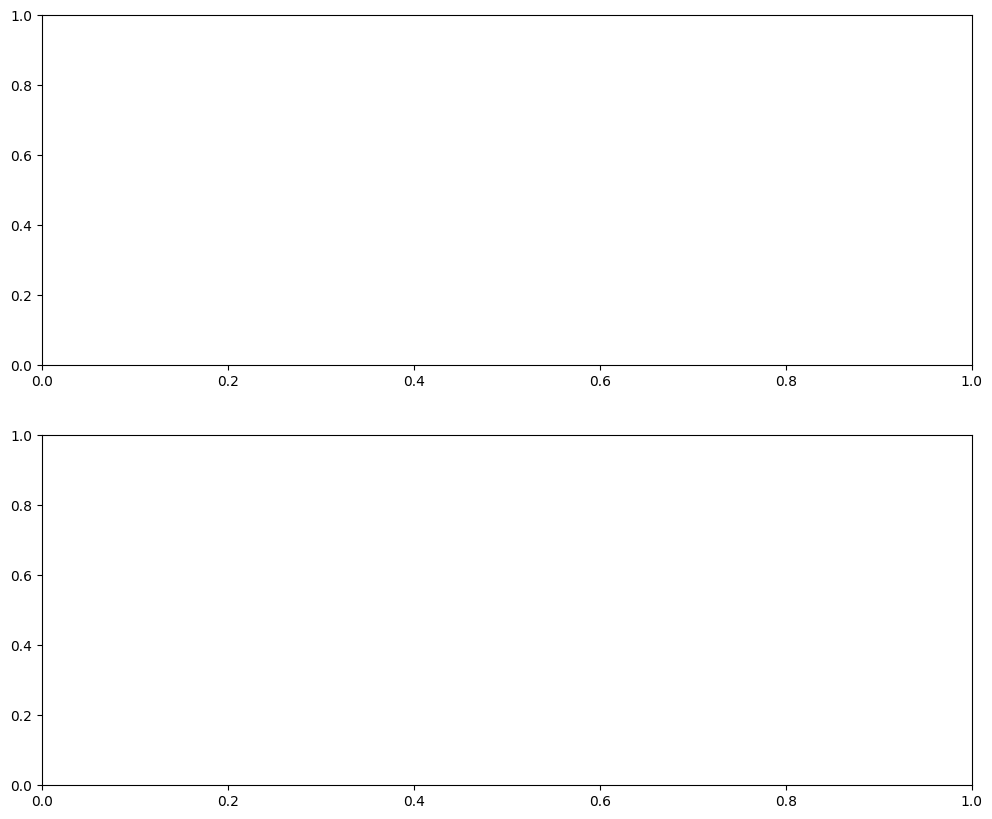

In [72]:
if __name__ == "__main__":
    main()